In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
transform=transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

In [3]:
class VAE(nn.Module):
    def __init__(self,latent_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 400)
        self.fc3 = nn.Linear(400, 784)
    def encode(self, x):
        h= F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def decode(self, z):
        h = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))
    def forward(self, x):
        x = x.view(-1, 28*28)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar
    
        

In [4]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim=20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        recon, mu, logvar = model(x)
        loss = vae_loss(recon, x, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader.dataset):.4f}")


Epoch [1/10], Loss: 164.9571
Epoch [2/10], Loss: 121.7280
Epoch [3/10], Loss: 114.7465
Epoch [4/10], Loss: 111.7608
Epoch [5/10], Loss: 109.9504
Epoch [6/10], Loss: 108.8290
Epoch [7/10], Loss: 107.9622
Epoch [8/10], Loss: 107.2797
Epoch [9/10], Loss: 106.8230
Epoch [10/10], Loss: 106.4286


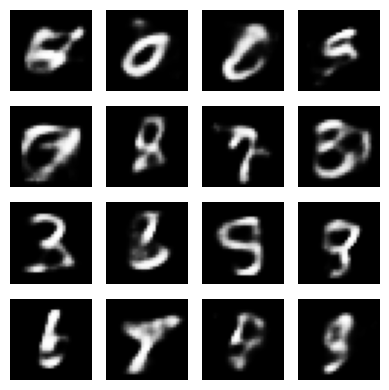

In [8]:
model.eval()
with torch.no_grad():
    z = torch.randn(16, 20).to(device)
    generated = model.decode(z).cpu()
    generated = generated.view(-1, 1, 28, 28)

    # Plot
    plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated[i][0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [9]:
class CVAE(nn.Module):
    def __init__(self, latent_dim=20, label_dim=10):
        super(CVAE, self).__init__()
        input_dim = 28*28 + label_dim

        # Encoder
        self.fc1 = nn.Linear(input_dim, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim + label_dim, 400)
        self.fc3 = nn.Linear(400, 28*28)
    
    def encode(self, x, y):
        inputs = torch.cat([x, y], dim=1)
        h = F.relu(self.fc1(inputs))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        inputs = torch.cat([z, y], dim=1)
        h = F.relu(self.fc2(inputs))
        return torch.sigmoid(self.fc3(h))
    
    def forward(self, x, y):
        x = x.view(-1, 28*28)
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, y)
        return recon, mu, logvar


In [11]:
def cvae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = CVAE(latent_dim=20).to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)

def one_hot(labels, num_classes=10):
    return F.one_hot(labels, num_classes=num_classes).float()

for epoch in range(10):
    model1.train()
    total_loss = 0
    for x, labels in train_loader:
        x = x.to(device)
        y = one_hot(labels).to(device)

        recon, mu, logvar = model1(x, y)
        loss = cvae_loss(recon, x, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset):.4f}")


Epoch 1, Loss: 163.3258
Epoch 2, Loss: 119.5408
Epoch 3, Loss: 112.3732
Epoch 4, Loss: 109.0366
Epoch 5, Loss: 107.0245
Epoch 6, Loss: 105.5930
Epoch 7, Loss: 104.5762
Epoch 8, Loss: 103.7485
Epoch 9, Loss: 103.0724
Epoch 10, Loss: 102.5208


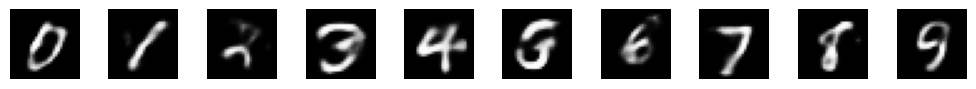

In [13]:
model1.eval()
with torch.no_grad():
    n = 10
    z = torch.randn(n, 20).to(device)
    y = one_hot(torch.arange(0, n)).to(device)  # labels 0 to 9
    samples = model1.decode(z, y).cpu().view(-1, 1, 28, 28)

    plt.figure(figsize=(10, 1))
    for i in range(n):
        plt.subplot(1, 10, i + 1)
        plt.imshow(samples[i][0], cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [14]:
class BetaCVAE(nn.Module):
    def __init__(self, latent_dim=20, label_dim=10):
        super(BetaCVAE, self).__init__()
        input_dim = 28*28 + label_dim

        # Encoder
        self.fc1 = nn.Linear(input_dim, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim + label_dim, 400)
        self.fc3 = nn.Linear(400, 28*28)
    
    def encode(self, x, y):
        h = F.relu(self.fc1(torch.cat([x, y], dim=1)))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        h = F.relu(self.fc2(torch.cat([z, y], dim=1)))
        return torch.sigmoid(self.fc3(h))
    
    def forward(self, x, y):
        x = x.view(-1, 28*28)
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, y)
        return recon, mu, logvar


In [15]:
def beta_cvae_loss(recon_x, x, mu, logvar, beta=4.0):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD


In [16]:
model2 = BetaCVAE(latent_dim=10).to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)

for epoch in range(15):
    model2.train()
    total_loss = 0
    for x, labels in train_loader:
        x = x.to(device)
        y = F.one_hot(labels, num_classes=10).float().to(device)

        recon, mu, logvar = model2(x, y)
        loss = beta_cvae_loss(recon, x, mu, logvar, beta=4.0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset):.4f}")


Epoch 1, Loss: 183.3028
Epoch 2, Loss: 150.8044
Epoch 3, Loss: 145.1860
Epoch 4, Loss: 142.0963
Epoch 5, Loss: 140.1886
Epoch 6, Loss: 138.9061
Epoch 7, Loss: 137.8799
Epoch 8, Loss: 137.1751
Epoch 9, Loss: 136.5697
Epoch 10, Loss: 136.0101
Epoch 11, Loss: 135.7042
Epoch 12, Loss: 135.2400
Epoch 13, Loss: 134.8741
Epoch 14, Loss: 134.6311
Epoch 15, Loss: 134.4227


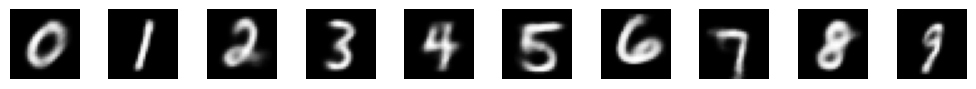

In [17]:
model2.eval()
with torch.no_grad():
    z = torch.randn(10, 10).to(device)  # Sample z
    y = F.one_hot(torch.arange(0, 10), num_classes=10).float().to(device)
    samples = model2.decode(z, y).cpu().view(-1, 1, 28, 28)

    plt.figure(figsize=(10, 1))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(samples[i][0], cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [18]:
def beta_cvae_loss(recon_x, x, mu, logvar, beta):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD


In [19]:
beta_values = [1, 4, 10, 20]


In [20]:
for beta in beta_values:
    print(f"\nTraining with β = {beta}")
    model2 = BetaCVAE(latent_dim=10).to(device)
    optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)

    for epoch in range(10):
        model2.train()
        total_loss = 0
        for x, labels in train_loader:
            x = x.to(device)
            y = F.one_hot(labels, num_classes=10).float().to(device)

            recon, mu, logvar = model2(x, y)
            loss = beta_cvae_loss(recon, x, mu, logvar, beta)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset):.4f}")
    
    # Save model for comparison
    torch.save(model2.state_dict(), f"cvae_beta_{beta}.pt")



Training with β = 1
Epoch 1, Loss: 161.0395
Epoch 2, Loss: 122.0053
Epoch 3, Loss: 116.0339
Epoch 4, Loss: 112.7487
Epoch 5, Loss: 110.6810
Epoch 6, Loss: 109.1380
Epoch 7, Loss: 107.9535
Epoch 8, Loss: 107.0702
Epoch 9, Loss: 106.2698
Epoch 10, Loss: 105.5932

Training with β = 4
Epoch 1, Loss: 183.4435
Epoch 2, Loss: 150.7630
Epoch 3, Loss: 144.9446
Epoch 4, Loss: 141.9057
Epoch 5, Loss: 139.9477
Epoch 6, Loss: 138.6793
Epoch 7, Loss: 137.8332
Epoch 8, Loss: 137.1786
Epoch 9, Loss: 136.5094
Epoch 10, Loss: 136.0444

Training with β = 10
Epoch 1, Loss: 193.9788
Epoch 2, Loss: 168.4800
Epoch 3, Loss: 164.4623
Epoch 4, Loss: 162.2115
Epoch 5, Loss: 161.0292
Epoch 6, Loss: 160.1009
Epoch 7, Loss: 159.5353
Epoch 8, Loss: 158.8913
Epoch 9, Loss: 158.6301
Epoch 10, Loss: 158.2160

Training with β = 20
Epoch 1, Loss: 196.6549
Epoch 2, Loss: 174.4891
Epoch 3, Loss: 173.3805
Epoch 4, Loss: 172.1818
Epoch 5, Loss: 171.1604
Epoch 6, Loss: 170.3899
Epoch 7, Loss: 169.9901
Epoch 8, Loss: 169.7337

In [24]:
def show_digit_generation(model2, beta):
    model2.eval()
    with torch.no_grad():
        z = torch.randn(10, 10).to(device)
        y = F.one_hot(torch.arange(0, 10), num_classes=10).float().to(device)
        samples = model2.decode(z, y).cpu().view(-1, 1, 28, 28)

        plt.figure(figsize=(10, 1))
        for i in range(10):
            plt.subplot(1, 10, i + 1)
            plt.imshow(samples[i][0], cmap="gray")
            plt.axis("off")
        plt.suptitle(f"β = {beta}")
        plt.tight_layout()
        plt.show()


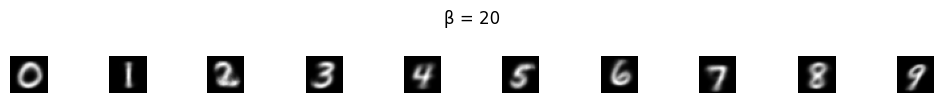

In [28]:
show_digit_generation(model2, beta)
